In [31]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [15]:
# Cargar los datos
file_path = 'datos_telecom_preprocesado.csv'

# Intentar cargar el archivo detectando automáticamente el delimitador
df = pd.read_csv(file_path)

# Verificar las primeras filas
df.head()

,ID,Genero,Casado,Edad,Graduado,Profesion,Experiencia laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,ingresos_anuales_brutos,Provincia,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campanna_anno
0,CLI2,1,0,-1.297819,0,3,2,-0.151048,0.798110,1.298075,2,-1.189304,28,-0.332995,-0.533086,0,-0.134417,0.353785
1,CLI3,0,1,-0.321216,1,4,0,1.465015,0.152186,0.321457,3,1.748442,35,0.031565,-0.533086,0,1.054800,0.353785
2,CLI4,0,1,1.414966,1,4,0,-0.151048,-1.139662,-1.414753,1,-0.072779,6,-0.190716,0.164441,0,0.550894,-1.568043
3,CLI5,1,1,1.414966,1,8,0,-1.767111,-0.493738,-1.414753,1,0.737793,14,-0.452758,0.164441,1,0.597925,0.353785
4,CLI6,0,1,-0.212705,1,7,0,-1.767111,2.089958,0.212944,1,0.977609,49,0.020547,-0.533086,1,0.006676,0.353785


In [16]:
# Excluir columnas no numéricas y la columna 'ID'
features = df.drop(['ID', 'Cluster'], axis=1, errors='ignore')

In [17]:
# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

In [18]:
# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

In [19]:
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

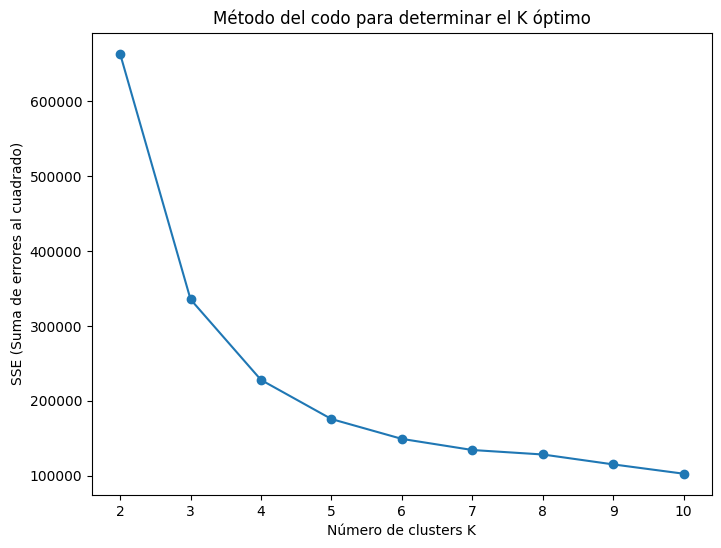

In [20]:
plt.figure(figsize=(8,6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clusters K')
plt.ylabel('SSE (Suma de errores al cuadrado)')
plt.title('Método del codo para determinar el K óptimo')
plt.show()

In [21]:
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, labels)
    silhouette_scores.append(silhouette_avg)

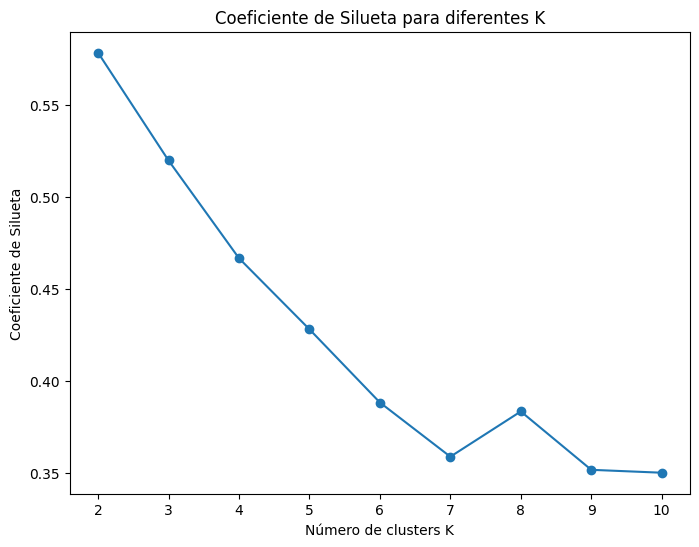

In [22]:
plt.figure(figsize=(8,6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Número de clusters K')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para diferentes K')
plt.show()

In [26]:
# Supongamos que el número óptimo de clusters es 4 basado en los gráficos anteriores
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pca)

In [27]:
# Método del Codo para determinar el número óptimo de clusters
inertia = []
cluster_range = range(1, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

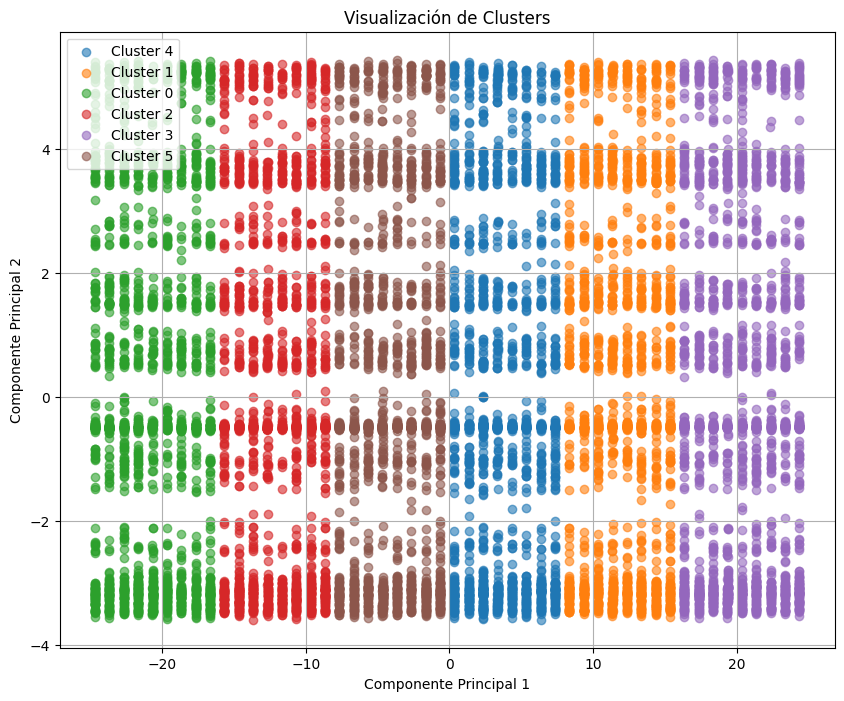

In [28]:
# Reducir a 2 componentes principales para visualización
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(features.drop(['ID', 'Abandono', 'Cluster'], axis=1, errors='ignore'))

# Crear un DataFrame con los clusters y las componentes principales
clustered_data = pd.DataFrame(X_pca_2d, columns=['PCA1', 'PCA2'])
clustered_data['Cluster'] = df['Cluster']

# Graficar los clusters
plt.figure(figsize=(10, 8))
for cluster in clustered_data['Cluster'].unique():
    cluster_points = clustered_data[clustered_data['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Visualización de Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Crear un nuevo DataFrame con los datos originales y las etiquetas de cluster
data_with_clusters = features.copy()
data_with_clusters['Cluster'] = df['Cluster']

In [35]:
from sklearn.preprocessing import StandardScaler

# Seleccionar solo columnas numéricas
numerical_features = features.select_dtypes(include=['float64', 'int64'])

# Aplicar StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Convertir a DataFrame
scaled_features = pd.DataFrame(scaled_features, columns=numerical_features.columns)

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(numerical_features)

scaled_features = pd.DataFrame(scaled_features, columns=numerical_features.columns)

In [39]:
# Supongamos que `scaled_features` contiene los datos escalados y `df['Cluster']` tiene los clusters
scaled_features['Cluster'] = df['Cluster']

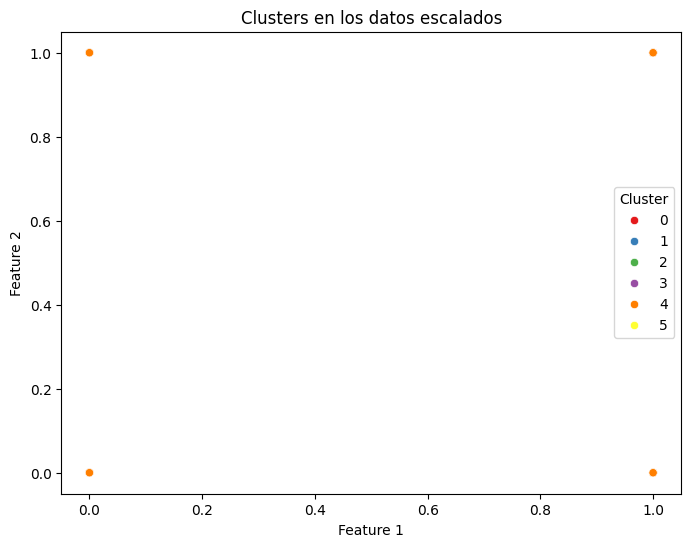

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_features.iloc[:, 0], y=scaled_features.iloc[:, 1], hue=scaled_features['Cluster'], palette='Set1')
plt.title('Clusters en los datos escalados')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

In [41]:
# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
reduced_data = pd.DataFrame(pca.fit_transform(scaled_features.drop('Cluster', axis=1)), columns=['PC1', 'PC2'])

# Agregar las etiquetas de clusters al DataFrame reducido
reduced_data['Cluster'] = scaled_features['Cluster']


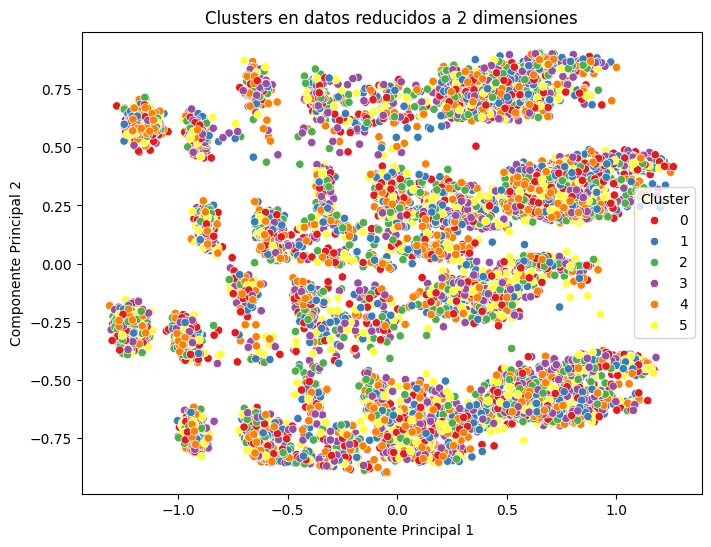

In [42]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data['PC1'], y=reduced_data['PC2'], hue=reduced_data['Cluster'], palette='Set1')
plt.title('Clusters en datos reducidos a 2 dimensiones')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()